In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import io
import pyarrow.parquet as pq
import pickle

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statistics import mean

Objective: Create separate hourly forecast for every bussiest roads

## Load Dataset

In [16]:
PATH_DATA='D:/DSLS/Data Science/data/raw/'
filename_store='/preprocessed_dataset.pkl'
filename_valid='/validation_dataset.pkl'
filename_rec = '/recurring_dataset.pkl'

with open(PATH_DATA+filename_store, 'rb') as f:
  df = pickle.load(f)

with open(PATH_DATA+filename_valid, 'rb') as f:
  df_val = pickle.load(f)

with open(PATH_DATA+filename_rec, 'rb') as f:
  df_rec = pickle.load(f)

Data Structure:
<br>
DF <br>
| <br>
| <br>
+------ ROAD_NAME: str <br>
|.           | <br>
|.           | <br>
|.           +------- WEEKDAYS: int <br>
| <br>
| <br>
| <br>

In [17]:
streets = ['Tol Jagorawi',
 'Lenteng Agung Barat',
 'Kranggan Raya',
 'Tol Cimanggis-Cibitung',
 'N6 Cinangka Raya',
 'N6 Jalan Raya Parung-Bogor',
 'Margonda Raya',
 'Sawangan Raya',
 'N8 Jalan Raya Bogor',
 'Cinere Raya']

In [18]:
df['Tol Jagorawi'][0].head()

,time_on_day,median_delay,median_length,median_speed_kmh
0,1,159.500000,7146.500000,57.065002
1,2,174.750000,5857.750000,50.185001
2,3,135.500000,4429.000000,49.476667
3,5,324.340909,4645.454545,39.445000
4,6,1366.954545,7644.272727,17.223636


## Modeling Prototype

Objective: Analyze performance of ML model to forecast sampled data

In [20]:
# Sampling
samples=list()
samples.append(df['Tol Jagorawi'][2])
samples.append(df['Kranggan Raya'][1])
samples.append(df['Tol Jagorawi'][3])
samples.append(df['Kranggan Raya'][3])
samples.append(df['Margonda Raya'][6])
samples.append(df['Margonda Raya'][4])

samples_rec = list()
samples_rec.append(df_rec['Tol Jagorawi'][2])
samples_rec.append(df_rec['Kranggan Raya'][1])
samples_rec.append(df_rec['Tol Jagorawi'][3])
samples_rec.append(df_rec['Kranggan Raya'][3])
samples_rec.append(df_rec['Margonda Raya'][6])
samples_rec.append(df_rec['Margonda Raya'][4])


### Splitting

Objective: Forecast model for median_delay

In [21]:
def split_train_test(data):
    train_data = data[:int(0.9*(len(data)))]
    test_data = data[int(0.9*(len(data))):]
    
    print(f"shape of train: {train_data.shape}")
    print(f"shape of test: {test_data.shape}")
    
    return train_data, test_data

In [22]:
train, test = split_train_test(samples[0])

shape of train: (13, 4)
shape of test: (2, 4)


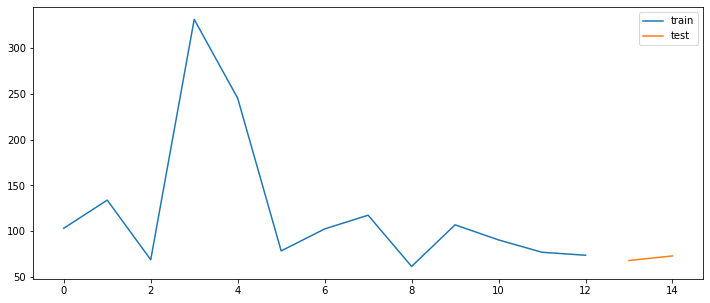

In [23]:
fig, ax=plt.subplots(figsize=(12, 5))
train['median_delay'].plot(ax=ax, label='train')
test['median_delay'].plot(ax=ax, label='test')
ax.legend();
plt.show()

In [24]:
train_r, test_r = split_train_test(samples_rec[0])

shape of train: (53, 15)
shape of test: (6, 15)


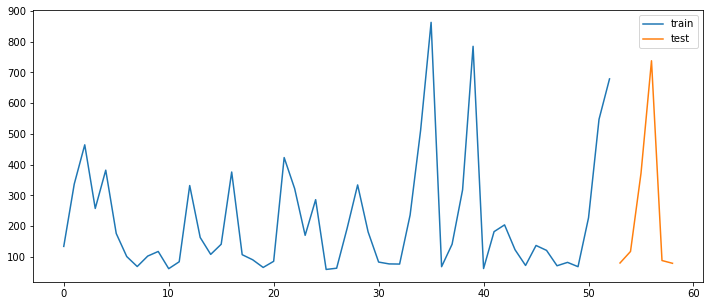

In [25]:
fig, ax=plt.subplots(figsize=(12, 5))
train_r['median_delay'].plot(ax=ax, label='train')
test_r['median_delay'].plot(ax=ax, label='test')
ax.legend();
plt.show()

## Daily

### Autoregressive Moving Average (ARMA) --> 54.8%

In [50]:
# change value here
metric = 'median_delay'

train, test = split_train_test(samples[0])

data_train= train[metric]
data_test= test[metric]

print(f"Train hours : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test hours  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

shape of train: (13, 4)
shape of test: (2, 4)
Train hours : 0 --- 12  (n=13)
Test hours  : 13 --- 14  (n=2)


In [51]:
y = data_train
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

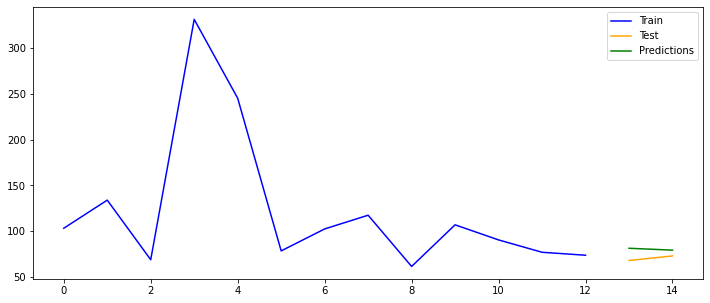

In [52]:
y_pred = ARMAmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [53]:
arma_mape = mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])
print(arma_mape)

0.14161787499862313


In [60]:
def black_box_arma():
    mape =  list()
    
    for sample in samples:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        ARMAmodel = SARIMAX(y, order = (1, 0, 1))
        ARMAmodel = ARMAmodel.fit()
        
        # predict
        y_pred = ARMAmodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (13, 4)
shape of test: (2, 4)


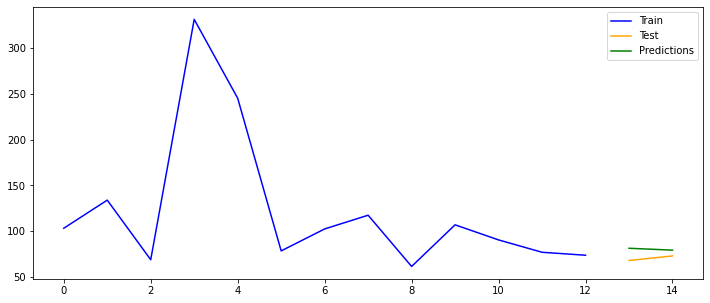

shape of train: (9, 4)
shape of test: (2, 4)


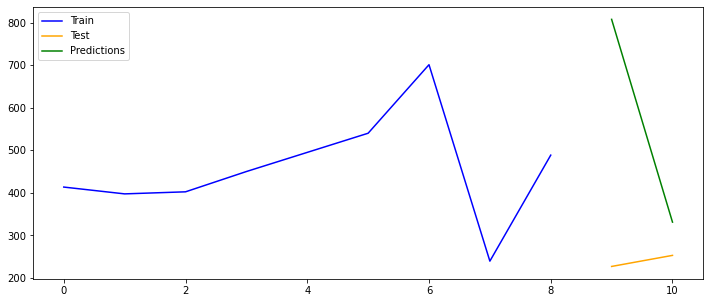

shape of train: (19, 4)
shape of test: (3, 4)


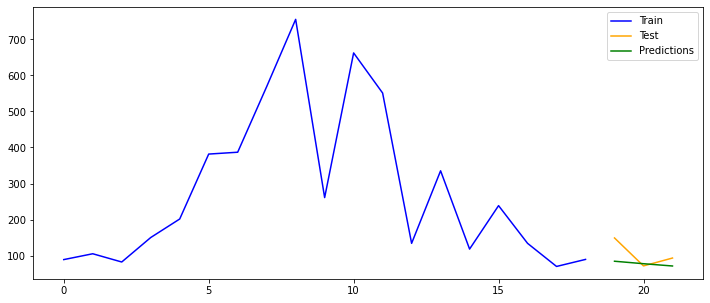

shape of train: (13, 4)
shape of test: (2, 4)


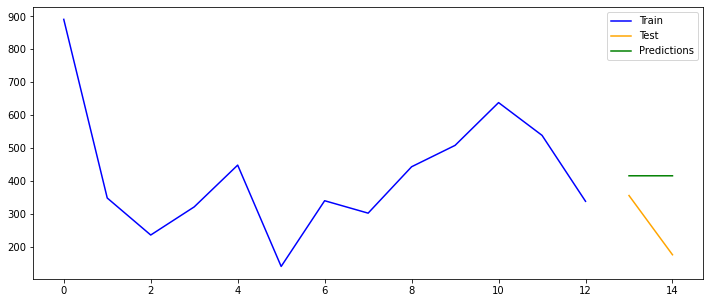

shape of train: (21, 4)
shape of test: (3, 4)


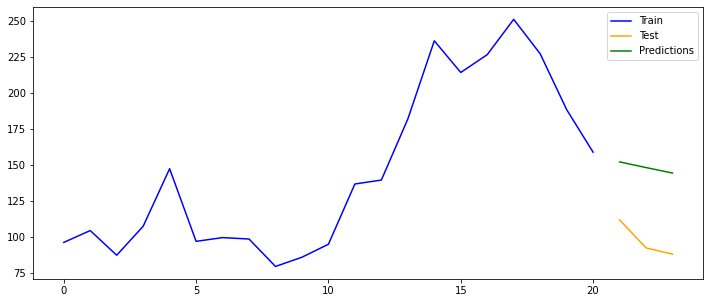

shape of train: (20, 4)
shape of test: (3, 4)


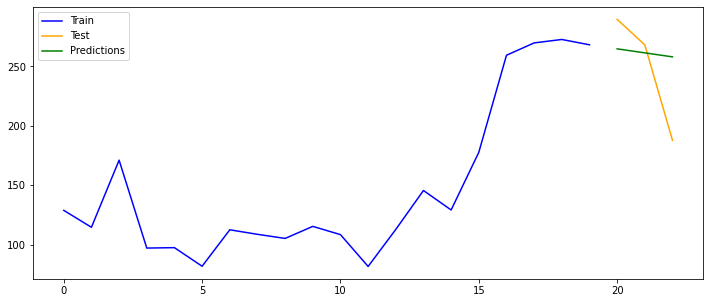

In [61]:
mape = black_box_arma()

In [62]:
print(mean(mape))

0.5481477295842495


### Autoregressive Integrated Moving Average (ARIMA) --> 53.1%

In [64]:
def black_box_arima():
    mape =  list()
    
    for sample in samples:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        ARIMAmodel = ARIMA(y, order = (2, 2, 2))
        ARIMAmodel = ARIMAmodel.fit()
        
        # predict
        y_pred = ARIMAmodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (13, 4)
shape of test: (2, 4)


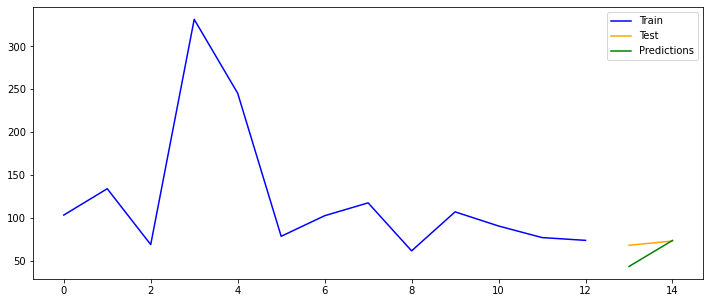

shape of train: (9, 4)
shape of test: (2, 4)


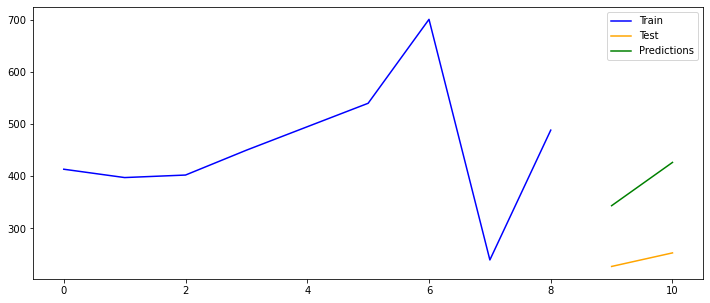

shape of train: (19, 4)
shape of test: (3, 4)


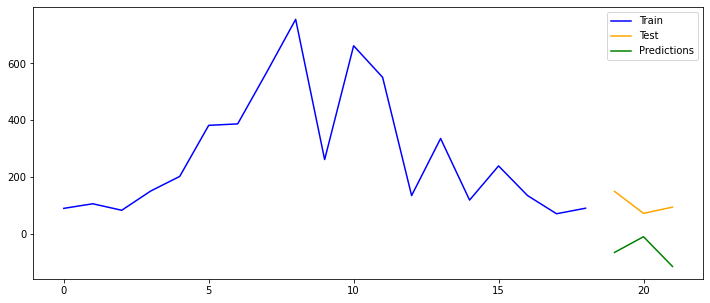

shape of train: (13, 4)
shape of test: (2, 4)


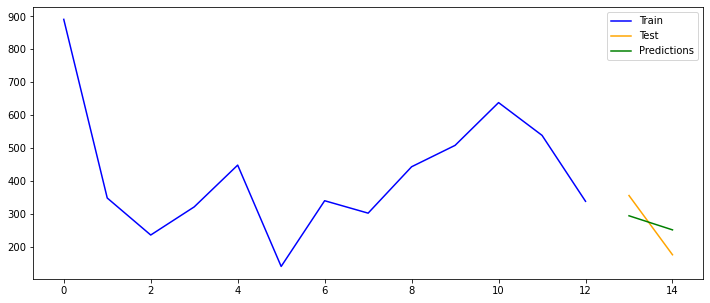

shape of train: (21, 4)
shape of test: (3, 4)


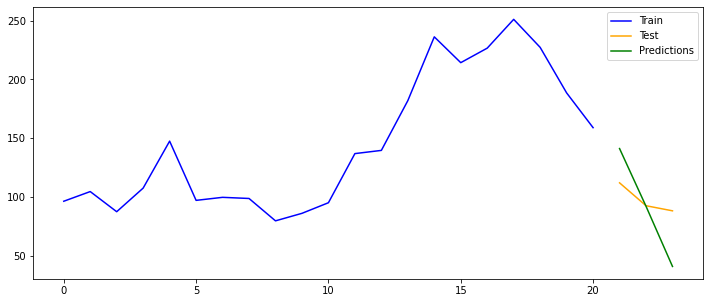

shape of train: (20, 4)
shape of test: (3, 4)


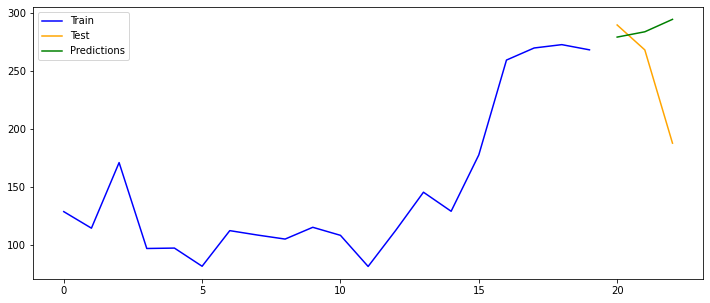

In [65]:
mape = black_box_arima()

In [66]:
print(mean(mape))

0.5314541995350757


### Seasonal ARIMA (SARIMA) --> 54.7%

In [69]:
def black_box_sarima():
    mape =  list()
    
    for sample in samples:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        sarimamodel = SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        sarimamodel = sarimamodel.fit()
        
        # predict
        y_pred = sarimamodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = sarimamodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (13, 4)
shape of test: (2, 4)


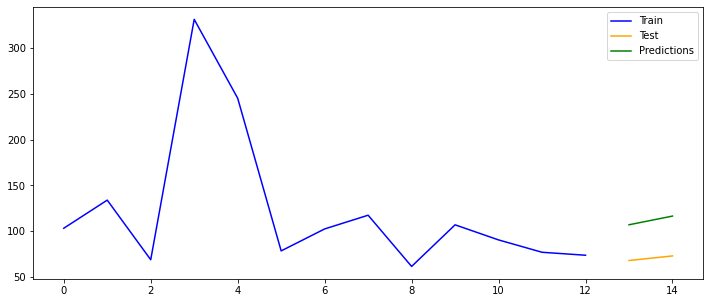

shape of train: (9, 4)
shape of test: (2, 4)


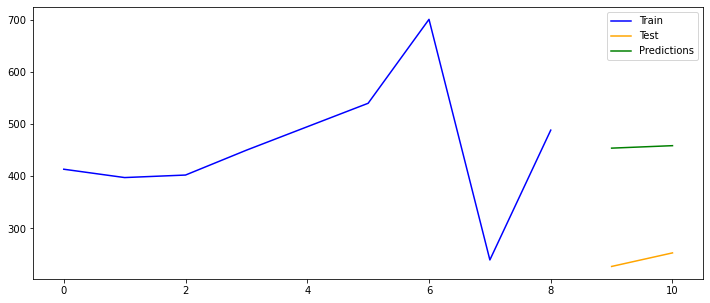

shape of train: (19, 4)
shape of test: (3, 4)


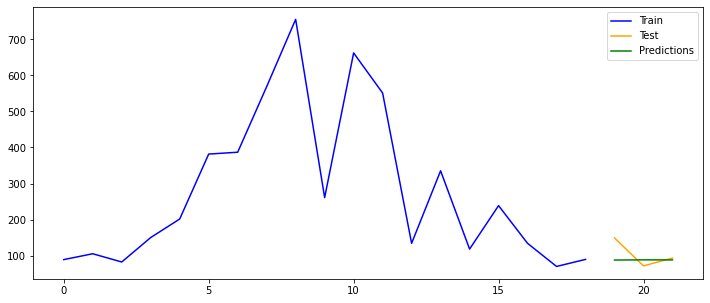

shape of train: (13, 4)
shape of test: (2, 4)


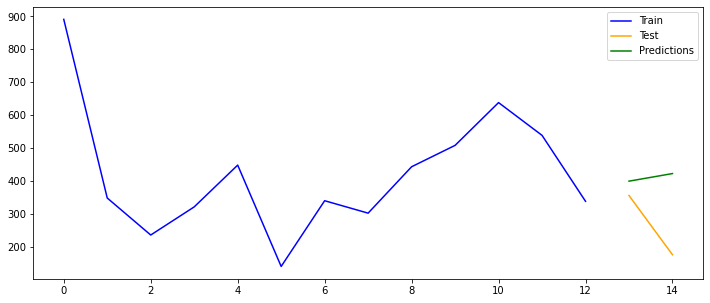

shape of train: (21, 4)
shape of test: (3, 4)


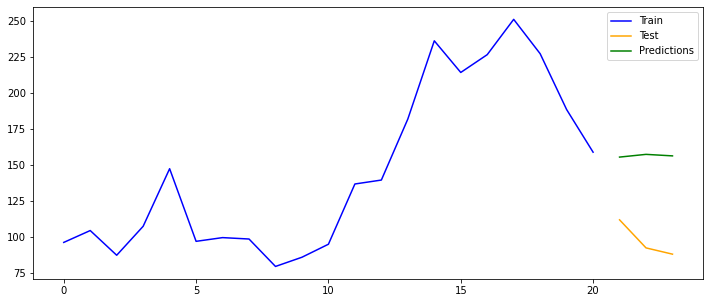

shape of train: (20, 4)
shape of test: (3, 4)


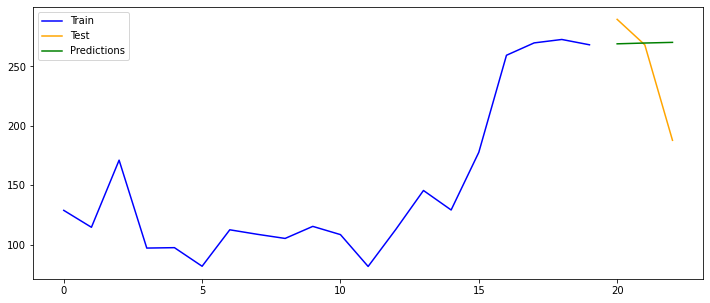

In [70]:
mape = black_box_sarima()

In [71]:
print(mean(mape))

0.5471680196313565


## Unsplitted

### Autoregressive Moving Average (ARMA) --> 113%

In [72]:
# change value here
metric = 'median_delay'

train_r, test_r = split_train_test(samples_rec[0])

data_train= train_r[metric]
data_test= test_r[metric]

print(f"Train hours : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test hours  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

shape of train: (53, 15)
shape of test: (6, 15)
Train hours : 0 --- 52  (n=53)
Test hours  : 53 --- 58  (n=6)


In [73]:
y = data_train
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

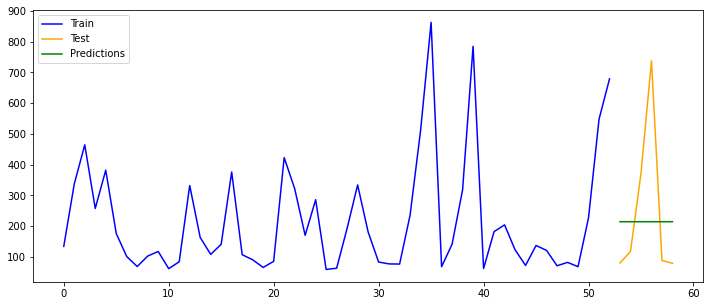

In [74]:
y_pred = ARMAmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [75]:
arma_mape = mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])
print(arma_mape)

1.1309995854819512


In [76]:
def black_box_arma():
    mape =  list()
    
    for sample in samples_rec:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        ARMAmodel = SARIMAX(y, order = (1, 0, 1))
        ARMAmodel = ARMAmodel.fit()
        
        # predict
        y_pred = ARMAmodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (53, 15)
shape of test: (6, 15)


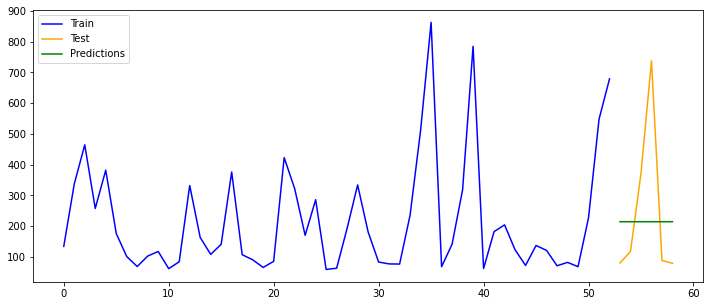

shape of train: (18, 15)
shape of test: (2, 15)


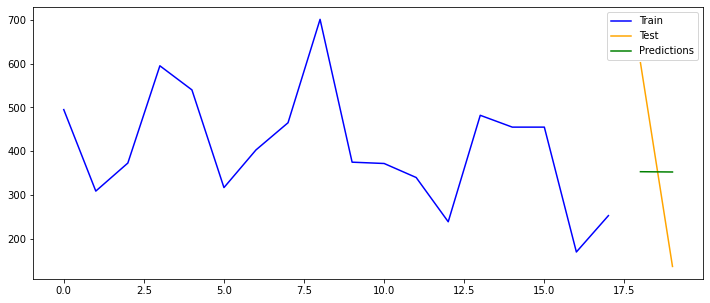

shape of train: (108, 15)
shape of test: (13, 15)


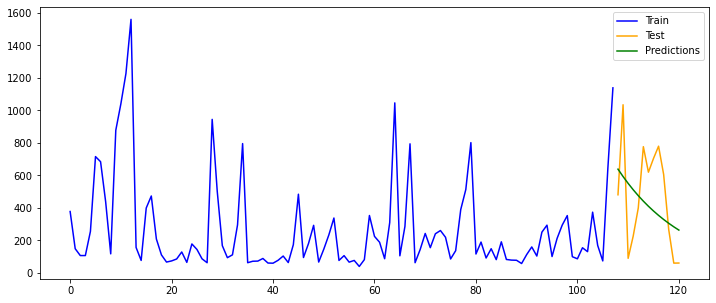

shape of train: (33, 15)
shape of test: (4, 15)


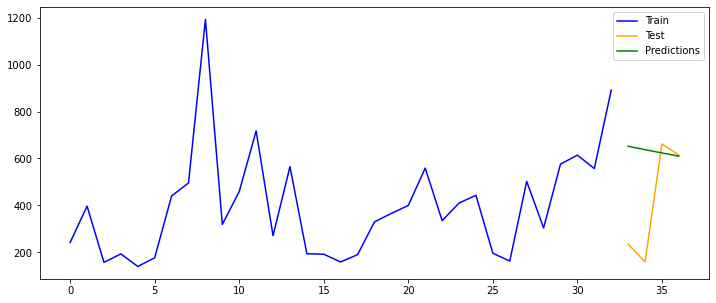

shape of train: (354, 15)
shape of test: (40, 15)


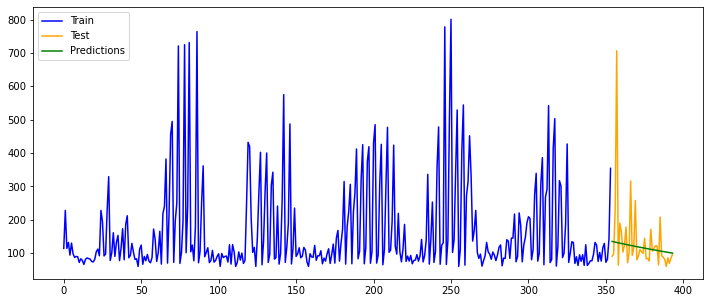

shape of train: (417, 15)
shape of test: (47, 15)


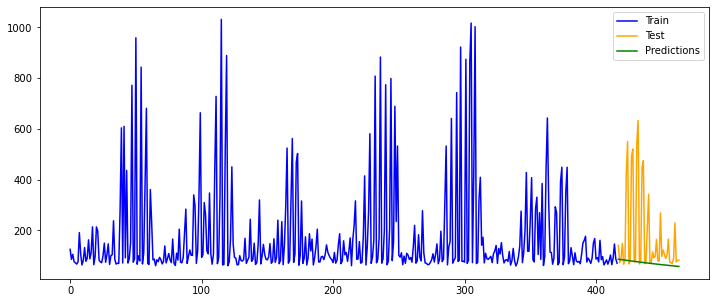

In [77]:
mape = black_box_arma()

In [78]:
mean(mape)

0.888107527562817

### Autoregressive Integrated Moving Average (ARIMA) --> 186%

In [79]:
# change value here
metric = 'median_delay'

train_r, test_r = split_train_test(samples_rec[0])

data_train= train_r[metric]
data_test= test_r[metric]

print(f"Train hours : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test hours  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

shape of train: (53, 15)
shape of test: (6, 15)
Train hours : 0 --- 52  (n=53)
Test hours  : 53 --- 58  (n=6)


In [80]:
y=data_train

ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()


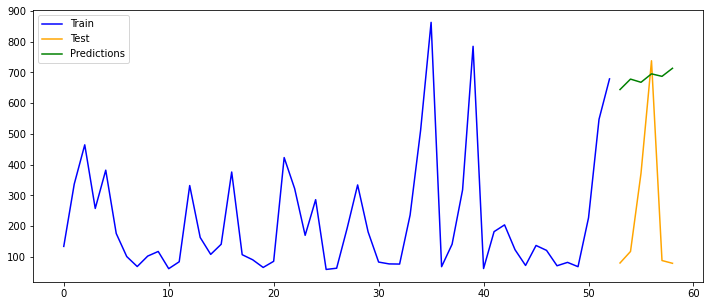

In [81]:
y_pred = ARIMAmodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()


In [82]:
mape=mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])

print("MAPE: ",mape)

MAPE:  4.587290528417032


In [83]:
def black_box_arima():
    mape =  list()
    
    for sample in samples_rec:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        ARIMAmodel = ARIMA(y, order = (2, 2, 2))
        ARIMAmodel = ARIMAmodel.fit()
        
        # predict
        y_pred = ARIMAmodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (53, 15)
shape of test: (6, 15)


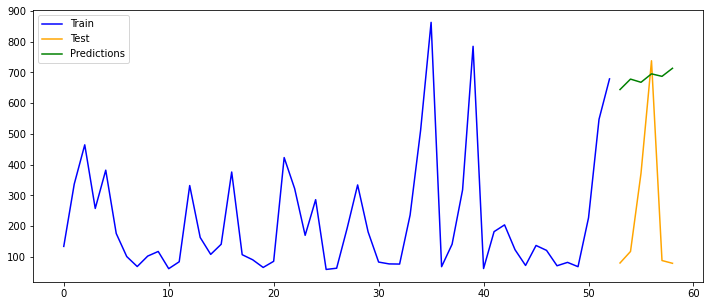

shape of train: (18, 15)
shape of test: (2, 15)


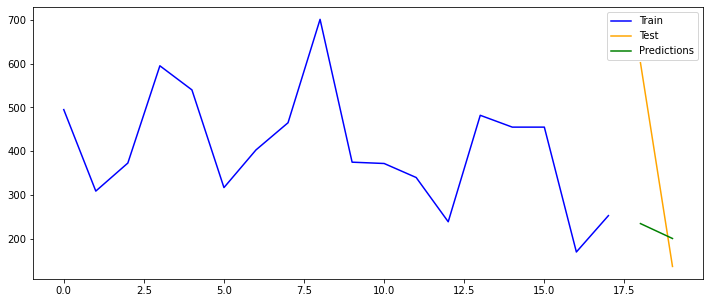

shape of train: (108, 15)
shape of test: (13, 15)


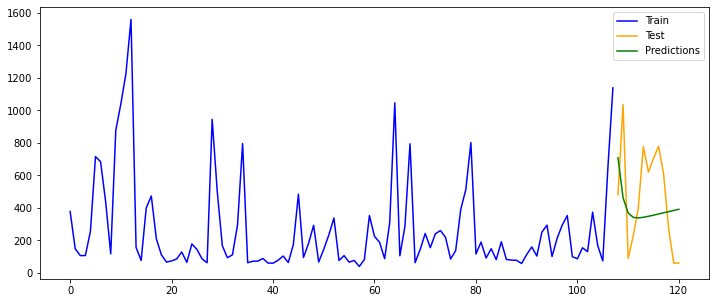

shape of train: (33, 15)
shape of test: (4, 15)


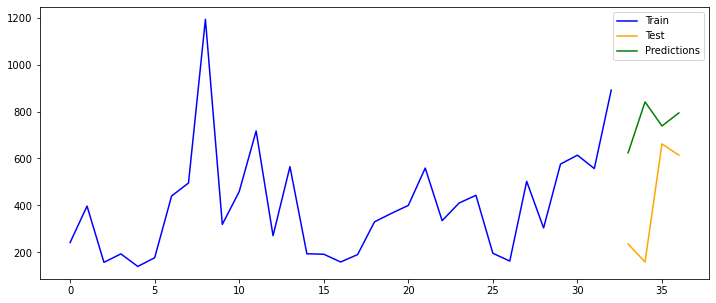

shape of train: (354, 15)
shape of test: (40, 15)


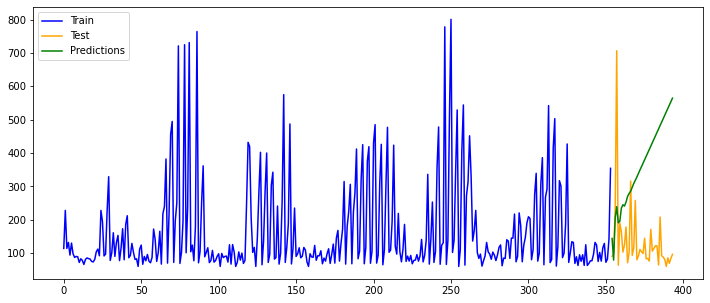

shape of train: (417, 15)
shape of test: (47, 15)


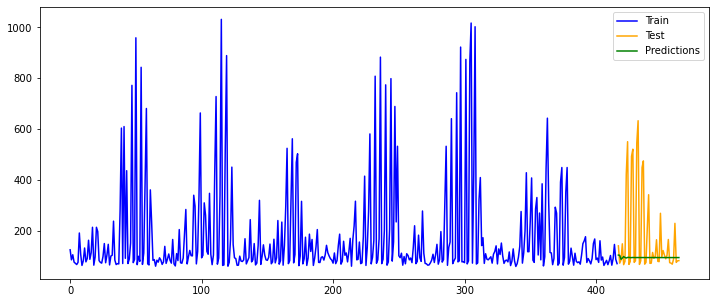

In [84]:
mape = black_box_arima()

In [85]:
mean(mape)

1.8617584032109271

### Seasonal ARIMA (SARIMA) --> 101%

In [86]:
sarimamodel = SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
sarimamodel = sarimamodel.fit()

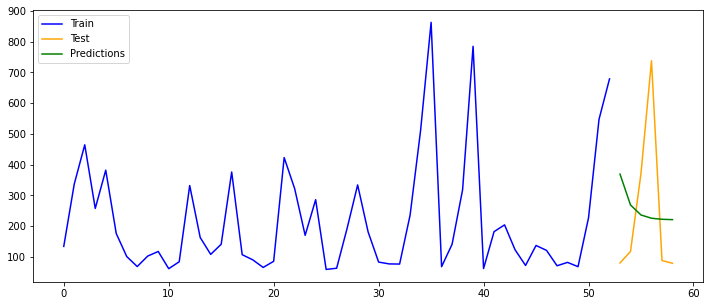

In [87]:
y_pred = sarimamodel.get_forecast(len(data_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = sarimamodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(12, 5))
plt.plot(data_train, color='blue', label = 'Train')
plt.plot(data_test, color='orange', label = 'Test')
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()


In [88]:
mape=mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"])

print("MAPE: ",mape)

MAPE:  1.5475302510298452


In [89]:
def black_box_sarima():
    mape =  list()
    
    for sample in samples_rec:
        # splitting
        train, test = split_train_test(sample)

        data_train=train['median_delay']
        data_test=test['median_delay']
        
        # modeling 
        y = data_train
        sarimamodel = SARIMAX(y, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        sarimamodel = sarimamodel.fit()
        
        # predict
        y_pred = sarimamodel.get_forecast(len(data_test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.1) 
        y_pred_df["Predictions"] = sarimamodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = data_test.index
        y_pred_out = y_pred_df["Predictions"] 
        
        #plot
        plt.figure(figsize=(12, 5))
        plt.plot(data_train, color='blue', label = 'Train')
        plt.plot(data_test, color='orange', label = 'Test')
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.legend()
        plt.show()
        
        mape.append(mean_absolute_percentage_error(data_test.values, y_pred_df["Predictions"]))
        
    return mape

shape of train: (53, 15)
shape of test: (6, 15)


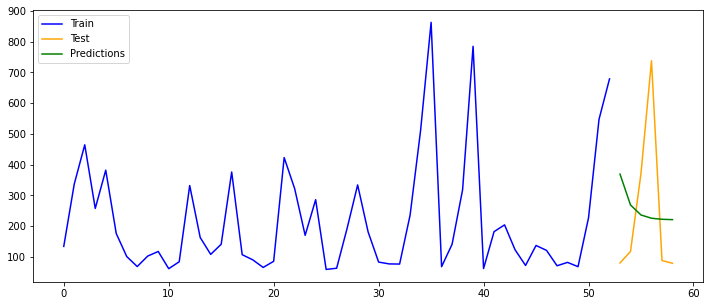

shape of train: (18, 15)
shape of test: (2, 15)


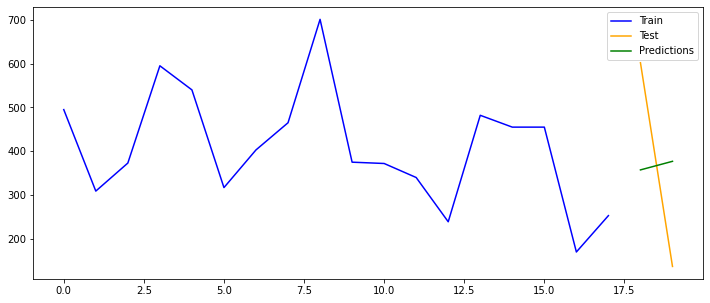

shape of train: (108, 15)
shape of test: (13, 15)


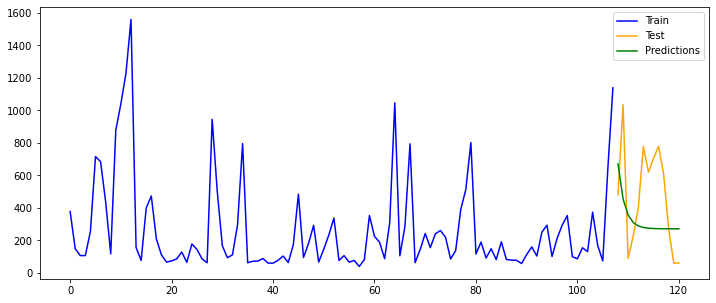

shape of train: (33, 15)
shape of test: (4, 15)


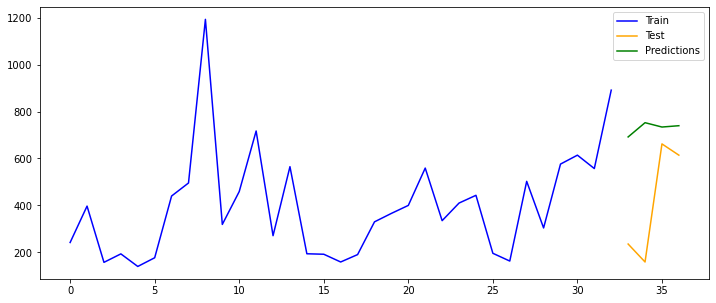

shape of train: (354, 15)
shape of test: (40, 15)


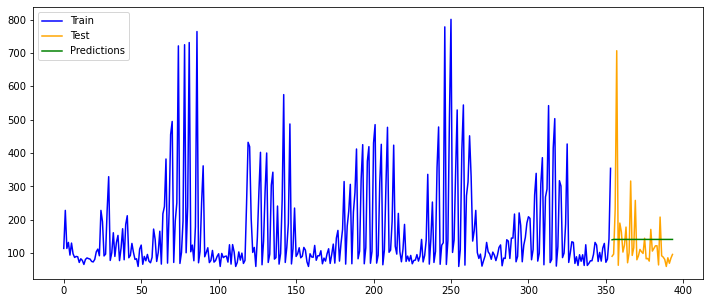

shape of train: (417, 15)
shape of test: (47, 15)


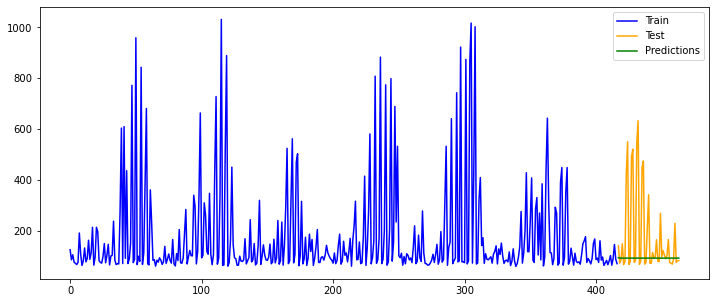

In [90]:
mape = black_box_sarima()

In [91]:
mean(mape)

1.0187704443232124

### Conclusion 

berdasarkan metric MAPE, maka model yang digunakan adalah model ARIMA